# 1. Mengimpor Library

---

Pada bab ini, kita akan mengimpor berbagai library yang diperlukan untuk analisis data dan pembuatan model. Library yang digunakan antara lain `pandas` untuk manipulasi data, `numpy` untuk operasi numerik, `seaborn` dan `matplotlib` untuk visualisasi data, serta `tensorflow` dan `keras` untuk pembuatan model machine learning. Selain itu, kita juga akan menggunakan `sklearn` untuk ekstraksi fitur dan pengukuran kesamaan.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2025-01-04 15:58:23.632730: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-04 15:58:23.636754: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-04 15:58:23.649235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-04 15:58:23.670521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-04 15:58:23.676994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 15:58:23.692934: I tensorflow/core/platform/cpu_feature_gu

# 2. Data Loading

---

Data yang digunakan dalam proyek ini diambil dari [Anime Recommendations Database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database/data) yang tersedia di Kaggle. Dataset ini terdiri dari dua file utama: `anime.csv` yang berisi informasi tentang berbagai anime, dan `rating.csv` yang berisi rating yang diberikan oleh pengguna untuk setiap anime.

In [2]:
df_anime = pd.read_csv("data/anime.csv")
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
df_rating = pd.read_csv("data/rating.csv")
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# 3. Data Understanding

---

Dataset ini berisi informasi tentang preferensi pengguna dari 73.516 pengguna pada 12.294 anime. Setiap pengguna dapat menambahkan anime ke daftar yang telah mereka selesaikan dan memberikan rating, dan dataset ini merupakan kompilasi dari rating tersebut. Sumber dataset ini dapat ditemukan di [Anime Recommendations Database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database/data).

## 3.1. Melihat ukuran data

In [4]:
anime_rows, anime_cols = df_anime.shape
rating_rows, rating_cols = df_rating.shape

print(f"Jumlah baris data anime: {anime_rows}")
print(f"Jumlah kolom data anime: {anime_cols}")
print()
print(f"Jumlah baris data rating: {rating_rows}")
print(f"Jumlah kolom data rating: {rating_cols}")

Jumlah baris data anime: 12294
Jumlah kolom data anime: 7

Jumlah baris data rating: 7813737
Jumlah kolom data rating: 3


Dataset `anime.csv` memiliki jumlah baris sebanyak **12.294** dan jumlah kolom sebanyak **7**. Ini menunjukkan bahwa terdapat 12.294 entri anime yang berbeda dengan 7 atribut yang mendeskripsikan setiap anime tersebut. Sementara itu, dataset `rating.csv` memiliki jumlah baris sebanyak **7.813.737** dan jumlah kolom sebanyak **3**. Berikut adalah penjelasan dari masing-masing kolom pada kedua dataset tersebut:

**anime.csv**

- anime_id : id unik myanimelist.net yang mengidentifikasi sebuah anime.
- name : nama lengkap anime.
- genre : daftar genre yang dipisahkan dengan koma untuk anime ini.
- type : film, TV, OVA, dll.
- episodes : berapa banyak episode dalam anime ini. (1 jika film).
- rating : rata-rata rating dari 10 untuk anime ini.
- members : jumlah anggota komunitas yang ada dalam "grup" anime ini.

**rating.csv**

- user_id : id unik myanimelist.net yang mengidentifikasi seorang pengguna.
- anime_id : anime yang telah dinilai oleh pengguna ini.
- rating : rating dari 10 yang diberikan pengguna ini (-1 jika pengguna menontonnya tetapi tidak memberikan rating).


## 3.2. Jumlah Data Unik

In [5]:
unique_anime_ids = df_anime['anime_id'].nunique()
unique_user_ids = df_rating['user_id'].nunique()

print(f"Jumlah data anime ID: {unique_anime_ids}")
print(f"Jumlah data user ID: {unique_user_ids}")

Jumlah data anime ID: 12294
Jumlah data user ID: 73515


Berdasarkan hasil perhitungan, terdapat sebanyak **12.294** data anime unik yang tersedia dalam dataset `anime.csv`. Selain itu, terdapat sebanyak **73.515** pengguna unik yang memberikan rating pada berbagai anime dalam dataset `rating.csv`.

## 3.3. Informasi Data

In [6]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Pada dataset `anime.csv`, terdapat beberapa kolom yang memiliki tipe data yang berbeda. Kolom `anime_id` dan `members` memiliki tipe data integer, kolom `name`, `genre`,  `type`, dan `episodes` memiliki tipe data string, sedangkan kolom `rating` memiliki tipe data float.

In [7]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Sementara itu, pada dataset `rating.csv`, semua kolom memiliki tipe data integer.

## 3.4. Statistik Deskriptif

In [8]:
df_anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Deskripsi statistik dari dataset `anime.csv` menunjukkan bahwa rata-rata rating anime adalah sebesar 6.47, dengan rating terendah sebesar 1.67 dan rating tertinggi sebesar 10. Sementara itu, anime dengan jumlah anggota terendah memiliki 5 anggota, sedangkan anime dengan jumlah anggota terbanyak memiliki 1.013.917 anggota.

In [10]:
df_rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Deskripsi statistik dari dataset `rating.csv` menunjukkan bahwa rata-rata rating yang diberikan oleh pengguna adalah sebesar 6.14, dengan rating terendah sebesar -1 dan rating tertinggi sebesar 10.

## 3.5. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) adalah proses untuk memahami data dengan cara menganalisis karakteristik utama dataset. Pada bagian ini, kita akan memvisualisasikan data untuk memahami distribusi dan pola dalam dataset.

### 3.5.1. Dataset `anime.csv`

#### 3.5.1.1. Top Anime Berdasarkan Jumlah Anggota

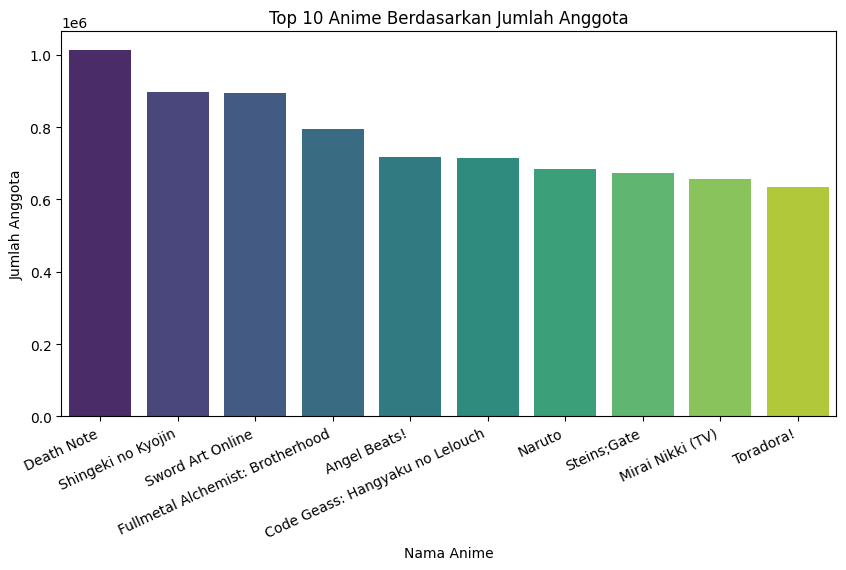

In [16]:
# Select top 10 anime based on the number of members
top_anime = df_anime.nlargest(10, 'members')

# Create a vertical bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x='name', y='members', data=top_anime, hue='name', palette='viridis', legend=False)
plt.title('Top 10 Anime Berdasarkan Jumlah Anggota')
plt.xlabel('Nama Anime')
plt.ylabel('Jumlah Anggota')
plt.xticks(rotation=25, ha='right')
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa anime dengan jumlah anggota terbanyak adalah anime dengan judul "`Death Note`" yang memiliki lebih dari 1 juta anggota, diikuti oleh anime "`Shingeki no Kyojin`" dan "`Sword Art Online`".

#### 3.5.1.2. Distribusi Tipe Anime

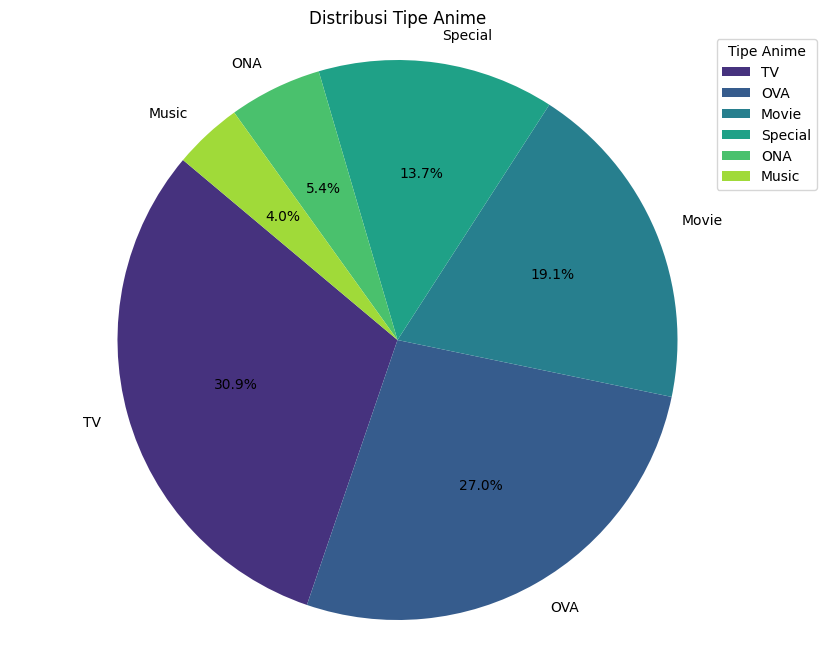

In [17]:
# Menghitung distribusi tipe anime
type_counts = df_anime['type'].value_counts()

# Membuat pie chart
plt.figure(figsize=(10, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(type_counts)))
plt.title('Distribusi Tipe Anime')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(type_counts.index, title="Tipe Anime", bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa anime dengan tipe `TV` adalah yang paling banyak, diikuti oleh anime dengan tipe `OVA`, `Movie`, `Special`, `ONA`, dan `Music` sebagai tipe anime yang paling sedikit.

#### 3.5.1.3. Distribusi Genre Anime

In [19]:
# Menghitung distribusi genre anime
genre_counts = df_anime['genre'].str.split(',').explode().value_counts()

# Convert the genre_counts Series to a DataFrame
df_genre_counts = genre_counts.reset_index()
df_genre_counts.columns = ['Genre', 'Count']
df_genre_counts

,Genre,Count
0,Comedy,3193
1,Action,2845
2,Sci-Fi,1986
3,Fantasy,1815
4,Shounen,1663
...,...,...
77,Police,1
78,Thriller,1
79,Super Power,1
80,Vampire,1


Dari visualisasi di atas, kita dapat melihat bahwa genre `Comey` adalah genre yang paling banyak, diikuti oleh genre `Action`, `Sci-Fi`, `Fantasy`, dan `Shounen`.

#### 3.5.1.4. Distribusi Rating Anime

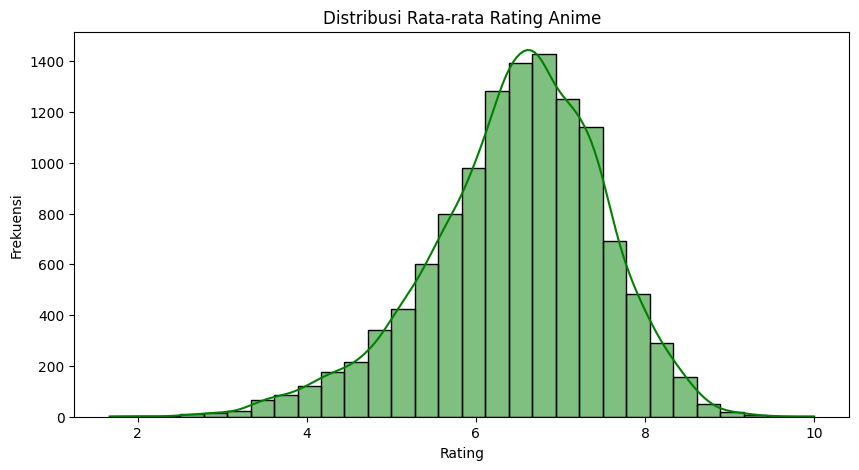

In [24]:
# Create a histogram for the distribution of average anime ratings
plt.figure(figsize=(10, 5))
sns.histplot(df_anime['rating'].dropna(), bins=30, kde=True, color='green')
plt.title('Distribusi Rata-rata Rating Anime')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Distribusi rating anime sebagian besar tersebar antara `5.5` hingga `8.0`. Hal ini menunjukkan bahwa mayoritas anime memiliki rating yang cukup baik, dengan sedikit anime yang memiliki rating sangat rendah atau sangat tinggi. Distribusi ini cenderung **left-skewed**, yang berarti lebih banyak anime yang memiliki rating di atas rata-rata dibandingkan dengan yang memiliki rating di bawah rata-rata. Skewness ini menunjukkan bahwa penonton cenderung memberikan rating yang lebih tinggi untuk anime yang mereka tonton.

### 3.5.2. Dataset `rating.csv`

#### 3.5.2.1. Pengguna dengan Rating Terbanyak

In [21]:
# Group by user_id and count the number of ratings for each user
user_rating_counts = df_rating.groupby('user_id').size().reset_index(name='rating_count')

# Sort the result by rating_count in descending order
user_rating_counts = user_rating_counts.sort_values(by='rating_count', ascending=False)

# Reset the index of the result DataFrame
user_rating_counts.reset_index(drop=True, inplace=True)

# Return the result as a DataFrame
user_rating_counts

,user_id,rating_count
0,48766,10227
1,42635,3747
2,53698,2905
3,57620,2702
4,59643,2633
...,...,...
73510,11323,1
73511,48775,1
73512,11328,1
73513,48743,1


Dari tabel di atas, kita dapat melihat bahwa pengguna dengan id `48766` memberikan rating terbanyak, yaitu sebanyak `10.227` anime.

#### 3.5.2.2. Distribusi Rating Pengguna

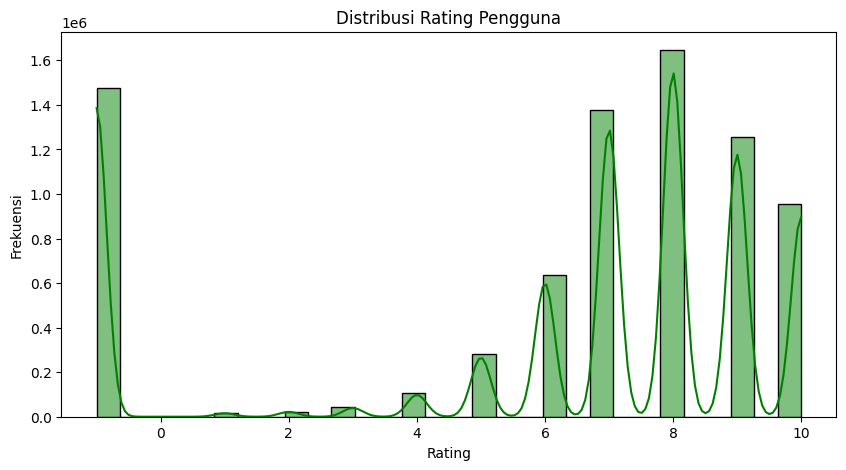

In [23]:
# Create a histogram for the distribution of user ratings
plt.figure(figsize=(10, 5))
sns.histplot(df_rating['rating'], bins=30, kde=True, color='green')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

Dari visualisasi di atas, kita dapat melihat bahwa sebagian besar pengguna memberikan rating antara `6` hingga `10`. Hal ini menunjukkan bahwa mayoritas pengguna memberikan rating yang cukup baik untuk anime yang mereka tonton. Selain itu, terdapat sejumlah pengguna yang memiliki rating `-1`, hal menunjukkan bahwa mereka menonton anime tersebut tetapi tidak memberikan rating. Data rating `-1` ini kemungkinan besar akan dihapus karena tidak memberikan informasi yang berguna dalam pembuatan model rekomendasi.

# 4. Data Preparation

---

Pada tahap ini, kita akan melakukan beberapa langkah data pre-preparation untuk mempersiapkan data sebelum digunakan dalam pembuatan model rekomendasi. Langkah-langkah pre-preparation yang akan dilakukan antara lain adalah filtering data, handling inrelevant data, handling missing values, dan handling duplicate data.

## 4.1. Filter Pengguna dengan Rating Sebanyak 500 atau Lebih

Filtering data rating sangat penting dilakukan karena dataset rating memiliki jumlah data yang sangat besar, mencapai jutaan entri. Dengan jumlah data yang sangat besar ini, penggunaan resource komputasi menjadi sangat tinggi dan dapat menyebabkan proses analisis data menjadi tidak efisien. Oleh karena itu, dilakukan filtering data untuk mengurangi jumlah data yang akan diproses. Salah satu cara yang digunakan adalah dengan menyaring pengguna yang memberikan rating sebanyak 500 atau lebih. Dengan melakukan filtering ini, kita dapat mengurangi jumlah data yang harus diproses tanpa mengorbankan kualitas analisis, sehingga penggunaan resource menjadi lebih efisien dan proses analisis data dapat berjalan lebih cepat.

In [29]:
rows, cols = df_rating.shape
print(f"Jumlah baris data rating sebelum filtering: {rows}")

Jumlah baris data rating sebelum filtering: 7813737


In [27]:
# Group by user_id and count the number of rated anime for each user
user_rating_counts = df_rating.groupby('user_id').size().reset_index(name='anime_count')

# Sort the result by anime_count in descending order
user_rating_counts = user_rating_counts.sort_values(by='anime_count', ascending=False)

# Display the result
user_rating_counts

,user_id,anime_count
48764,48766,10227
42634,42635,3747
53696,53698,2905
57618,57620,2702
59641,59643,2633
...,...,...
11322,11323,1
48773,48775,1
11327,11328,1
48741,48743,1


In [28]:
# Menghitung jumlah pengguna dengan anime_count >= 500
users_with_500_or_more = user_rating_counts[user_rating_counts['anime_count'] >= 500].shape[0]

# Menghitung jumlah pengguna dengan anime_count < 500
users_with_less_than_500 = user_rating_counts[user_rating_counts['anime_count'] < 500].shape[0]

print(f"Jumlah pengguna dengan anime_count >= 500: {users_with_500_or_more}")
print(f"Jumlah pengguna dengan anime_count < 500: {users_with_less_than_500}")

Jumlah pengguna dengan anime_count >= 500: 1853
Jumlah pengguna dengan anime_count < 500: 71662


In [30]:
filtered_users = user_rating_counts[user_rating_counts['anime_count'] >= 500]

# Filter df_rating to include only users with anime_count >= 500
df_rating = df_rating[df_rating['user_id'].isin(filtered_users['user_id'])]

# Display the shape of the filtered dataframe
rows, cols = df_rating.shape
print(f"Jumlah baris data rating setelah filtering: {rows}")

Jumlah baris data rating setelah filtering: 1384631


Dari hasil filtering data, kita dapat melihat bahwa terdapat sebanyak **1,853** pengguna yang memberikan rating sebanyak 500 atau lebih. Dengan melakukan filtering ini, kita dapat mengurangi jumlah data yang harus diproses dari **7.813.737** menjadi **1.384.631**.

## 4.2. Menghapus Data yang Tidak Relevan

Pada dataset `rating.csv`, terdapat beberapa anime yang memiliki rating `-1`. Data ini akan dihapus karena tidak memberikan informasi yang berguna dalam pembuatan model rekomendasi.

In [31]:
# Melihat value count dari rating user
df_rating['rating'].value_counts()

rating
-1     289627
 8     281036
 7     280571
 9     162049
 6     151486
 10     99668
 5      71751
 4      26542
 3      11488
 2       6197
 1       4216
Name: count, dtype: int64

Terdapat sebanyak `289.627` data rating yang memiliki rating `-1`. Data ini akan dihapus dari dataframe `df_rating`.

In [32]:
df_rating = df_rating[df_rating['rating'] != -1]

# Melihat value count dari rating user
df_rating['rating'].value_counts()

rating
8     281036
7     280571
9     162049
6     151486
10     99668
5      71751
4      26542
3      11488
2       6197
1       4216
Name: count, dtype: int64

Terlihat bahwa rating `-1` telah dihapus dari dataframe `df_rating`.

## 4.4. Menangani Data Duplikat

In [34]:
# Check for duplicate rows in the dataframe
duplicate_rows = df_anime[df_anime.duplicated()]

# Print the number of duplicate rows
print(f"Jumlah baris duplikat dalam dataframe anime: {duplicate_rows.shape[0]}")

Jumlah baris duplikat dalam dataframe anime: 0


In [35]:
# Check for duplicate rows in the dataframe
duplicate_rows = df_rating[df_rating.duplicated()]

# Print the number of duplicate rows
print(f"Jumlah baris duplikat dalam dataframe rating: {duplicate_rows.shape[0]}")

Jumlah baris duplikat dalam dataframe rating: 0


Pada penanganan data duplikat, terlihat bahwa tidak ada data duplikat yang ditemukan dalam dataset `anime.csv` maupun `rating.csv`.

# 5. Data Modeling

---

Pada tahap ini, kita akan membuat model rekomendasi menggunakan metode **Content-Based Filtering** dan **Collaborative Filtering**. Kita akan menggunakan algoritma machine learning `K-Nearest Neighbors (KNN)` untuk membuat model rekomendasi **Content-Based Filtering**, dan algoritma deep learning `RecommenderNet` untuk membuat model rekomendasi **Collaborative Filtering**.

## 5.1. Content-based Filtering (K-Nearest Neighbors)

Content-based Filtering adalah metode rekomendasi yang berfokus pada konten dari item yang direkomendasikan. Pada metode ini, rekomendasi diberikan berdasarkan kesamaan antara item yang direkomendasikan dengan item yang telah disukai oleh pengguna. Salah satu algoritma yang dapat digunakan dalam Content-based Filtering adalah algoritma `K-Nearest Neighbors (KNN)`.

In [38]:
# Hapus baris dengan nilai kosong pada kolom 'genre'
anime = df_anime.dropna(subset=['genre'])
anime.head(1)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630


Kita akan menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengekstraksi fitur dari data anime. TF-IDF adalah metode yang digunakan untuk mengekstraksi fitur dari teks dengan memberikan bobot pada kata-kata yang muncul dalam teks. Dalam kasus ini, kita akan menggunakan kolom `genre` dari dataset `anime.csv` sebagai teks yang akan diekstraksi fiturnya.

In [40]:
# Membuat TF-IDF Vectorizer untuk mentransformasi kolom 'genre'
tfidf = TfidfVectorizer()
# Fit dan transform kolom 'genre'
tfidf_matrix = tfidf.fit_transform(anime['genre'])

In [41]:
# Mengubah matriks TF-IDF menjadi array
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29450574, 0.31749916, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25046406, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Setelah melakukan ekstraksi fitur, kita akan menggunakan algoritma `K-Nearest Neighbors (KNN)` untuk membuat model rekomendasi. Pada parameter `metric`, kita akan menggunakan `cosine` untuk mengukur kesamaan antara item, dan pada parameter `algorithm`, kita akan menggunakan `brute` untuk menghitung jarak antara item.

In [42]:
# Inisialisasi NearestNeighbors model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

In [43]:
# Latih model NearestNeighbors
knn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [44]:
# Fungsi untuk mendapatkan rekomendasi berdasarkan model NearestNeighbors
def get_knn_recommendations(title, knn_model, anime, n=10):
    # Mendapatkan indeks anime yang sesuai dengan judul
    idx = anime[anime['name'] == title].index[0]

    # Mendapatkan vektor TF-IDF untuk anime yang diberikan
    tfidf_vector = tfidf_matrix[idx]

    # Menemukan n tetangga terdekat
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=n+1)

    # Mendapatkan indeks dari n anime yang paling mirip
    anime_indices = indices.flatten()[1:]

    # Mengembalikan n anime yang paling mirip
    return anime.iloc[anime_indices][['anime_id', 'name', 'genre', 'rating', 'members']]

In [58]:
# Mendapatkan judul anime random dari dataset
judul_random = random.choice(anime['name'].tolist())
# Mencetak judul anime random dan genrenya
genre_random = anime[anime['name'] == judul_random]['genre'].values[0]

print(f"Judul anime random: {judul_random}")
print(f"Genre dari anime random: {genre_random}")

# Mendapatkan rekomendasi untuk judul anime random menggunakan KNN
rekomendasi_knn = get_knn_recommendations(judul_random, knn_model, anime, n=5)
rekomendasi_knn

Judul anime random: Silent Mobius: The Motion Picture
Genre dari anime random: Adventure, Sci-Fi, Supernatural


,anime_id,name,genre,rating,members
1439,1069,Chou Denji Machine Voltes V,"Action, Adventure, Drama, Mecha, Sci-Fi, Shounen",7.54,3201
2005,411,Gun x Sword,"Action, Adventure, Drama, Mecha, Sci-Fi, Shounen",7.38,45921
2386,2747,Tetsuwan Atom,"Action, Adventure, Drama, Mecha, Sci-Fi, Shounen",7.28,5332
5261,10342,Tetsuwan Atom: Uchuu no Yuusha,"Action, Adventure, Drama, Mecha, Sci-Fi, Shounen",6.51,661
7721,1626,Genma Taisen,"Action, Adventure, Comedy, Drama, Mecha, Sci-F...",5.10,2055


Dari hasil rekomendasi, kita dapat melihat bahwa anime yang direkomendasikan memiliki genre yang mirip dengan anime random yang terpilih. Hal ini menunjukkan bahwa model rekomendasi Content-based Filtering menggunakan algoritma K-Nearest Neighbors (KNN) telah berhasil memberikan rekomendasi yang sesuai dengan preferensi pengguna.

## 5.2. Collaborative Filtering (RecommenderNet)

Collaborative Filtering adalah metode rekomendasi yang berfokus pada hubungan antara pengguna dan item. Pada metode ini, rekomendasi diberikan berdasarkan kesamaan antara pengguna dan item yang telah disukai oleh pengguna.

Di sini, kita akan membuat class RecommenderNet menggunakan class Model dari Keras. Kode class RecommenderNet ini diadaptasi dari tutorial di situs Keras dengan beberapa penyesuaian untuk kasus yang sedang kita selesaikan.

In [59]:
class RecommenderNet(Model):
    def __init__(self, num_users, num_anime, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer='l2')
        self.anime_embedding = Embedding(num_anime, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer='l2')
        self.user_bias = Embedding(num_users, 1)
        self.anime_bias = Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 0])
        anime_bias = self.anime_bias(inputs[:, 1])
        dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)
        x = dot_user_anime + user_bias + anime_bias
        return tf.nn.sigmoid(x)

Selanjutnya kita akan menyandikan (encode) data user_id dan anime_id ke dalam indeks integer. Selain itu, kita juga akan mencari data rating terendah dan tertinggi yang akan digunakan dalam proses splitting data nanti.

In [60]:
rating = df_rating

# Create encoded mapping for user_id and anime_id
user_id_mapping = {id:i for i, id in enumerate(rating['user_id'].unique())}
print(f'user_id_mapping: {user_id_mapping}')
anime_id_mapping = {id:i for i, id in enumerate(rating['anime_id'].unique())}
print(f'anime_id_mapping: {anime_id_mapping}')

# Create reverse mapping for user_id and anime_id
inverse_user_id_mapping = {i:id for id, i in user_id_mapping.items()}
print(f'inverse_user_id_mapping: {inverse_user_id_mapping}')
inverse_anime_id_mapping = {i:id for id, i in anime_id_mapping.items()}
print(f'inverse_anime_id_mapping: {inverse_anime_id_mapping}')

# Map user_id and anime_id to their respective indices
rating.loc[:, 'user_id'] = rating['user_id'].map(user_id_mapping)
rating.loc[:, 'anime_id'] = rating['anime_id'].map(anime_id_mapping)

# Number of unique users and anime in the dataset
num_users = rating['user_id'].nunique()
num_anime = rating['anime_id'].nunique()

# Minimum and maximum ratings in the dataset
min_rating = min(rating['rating'])
max_rating = max(rating['rating'])

# Create a DataFrame to display the number of users, number of anime, minimum rating, and maximum rating
df_counts = pd.DataFrame({
    'num_users': [num_users],
    'num_anime': [num_anime],
    'min_rating': [min_rating],
    'max_rating': [max_rating]
})

df_counts

user_id_mapping: {17: 0, 201: 1, 226: 2, 271: 3, 294: 4, 342: 5, 392: 6, 446: 7, 478: 8, 661: 9, 741: 10, 771: 11, 786: 12, 804: 13, 917: 14, 958: 15, 1019: 16, 1103: 17, 1145: 18, 1176: 19, 1191: 20, 1287: 21, 1338: 22, 1344: 23, 1456: 24, 1497: 25, 1504: 26, 1522: 27, 1530: 28, 1720: 29, 1822: 30, 1984: 31, 2200: 32, 2273: 33, 2297: 34, 2378: 35, 2632: 36, 2695: 37, 2701: 38, 2810: 39, 2820: 40, 2951: 41, 3009: 42, 3040: 43, 3117: 44, 3124: 45, 3127: 46, 3193: 47, 3203: 48, 3338: 49, 3391: 50, 3476: 51, 3500: 52, 3557: 53, 3569: 54, 3573: 55, 3597: 56, 3615: 57, 3657: 58, 3695: 59, 4064: 60, 4102: 61, 4168: 62, 4177: 63, 4215: 64, 4350: 65, 4468: 66, 4512: 67, 4749: 68, 4759: 69, 4814: 70, 4834: 71, 4842: 72, 4843: 73, 4883: 74, 4948: 75, 4979: 76, 4987: 77, 5053: 78, 5056: 79, 5073: 80, 5076: 81, 5137: 82, 5148: 83, 5244: 84, 5249: 85, 5264: 86, 5296: 87, 5310: 88, 5311: 89, 5325: 90, 5335: 91, 5357: 92, 5374: 93, 5394: 94, 5421: 95, 5428: 96, 5492: 97, 5504: 98, 5516: 99, 5555: 100

,num_users,num_anime,min_rating,max_rating
0,1755,9612,1,10


Lalu, kita akan membagi data menjadi data training dan data testing dengan rasio 70:30. Data training akan digunakan untuk melatih model, sedangkan data testing akan digunakan untuk mengevaluasi model.

In [62]:
# Prepare the training data
X_train = rating[['user_id', 'anime_id']].values
y_train = rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Print the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (766502, 2)
y_train shape: (766502,)
X_test shape: (328502, 2)
y_test shape: (328502,)


Setelah itu, kita akan membuat model Collaborative Filtering menggunakan class RecommenderNet yang telah kita buat sebelumnya. Model ini akan dilatih menggunakan data training yang telah kita bagi sebelumnya.

Dalam proses training, kita akan menggunakan `Adam` sebagai optimizer, `mean_squared_error` sebagai loss function, dan `mean_absolute_error` sebagai metrics. Selain itu, kita juga akan menggunakan `EarlyStopping` untuk menghentikan proses training jika tidak terjadi peningkatan performa model.

In [75]:
%%time


# Define the model
model = RecommenderNet(num_users, num_anime, embedding_size=50)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with Early Stopping
history = model.fit(x=X_train, y=y_train, batch_size=512, epochs=20, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.1750 - mean_absolute_error: 0.1916 - val_loss: 0.0247 - val_mean_absolute_error: 0.1232
Epoch 2/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0225 - mean_absolute_error: 0.1167 - val_loss: 0.0192 - val_mean_absolute_error: 0.1062
Epoch 3/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0185 - mean_absolute_error: 0.1042 - val_loss: 0.0178 - val_mean_absolute_error: 0.1017
Epoch 4/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0174 - mean_absolute_error: 0.1004 - val_loss: 0.0173 - val_mean_absolute_error: 0.0999
Epoch 5/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0170 - mean_absolute_error: 0.0989 - val_loss: 0.0171 - val_mean_absolute_error: 0.0992
Epoch 6/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0168 - mean_absolute_error: 0.0981 - val_loss: 0.0170 - val_mean_absolute_error: 0.0988
Epoch 7/20
1498/1498 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0167 - mean_absol

Dari output di atas, pelatihan model berhenri setelah `15` epoch dengan nilai mean squared error terendah sebesar `0.0165` dan nilai mean absolute error sebesar `0.0969`

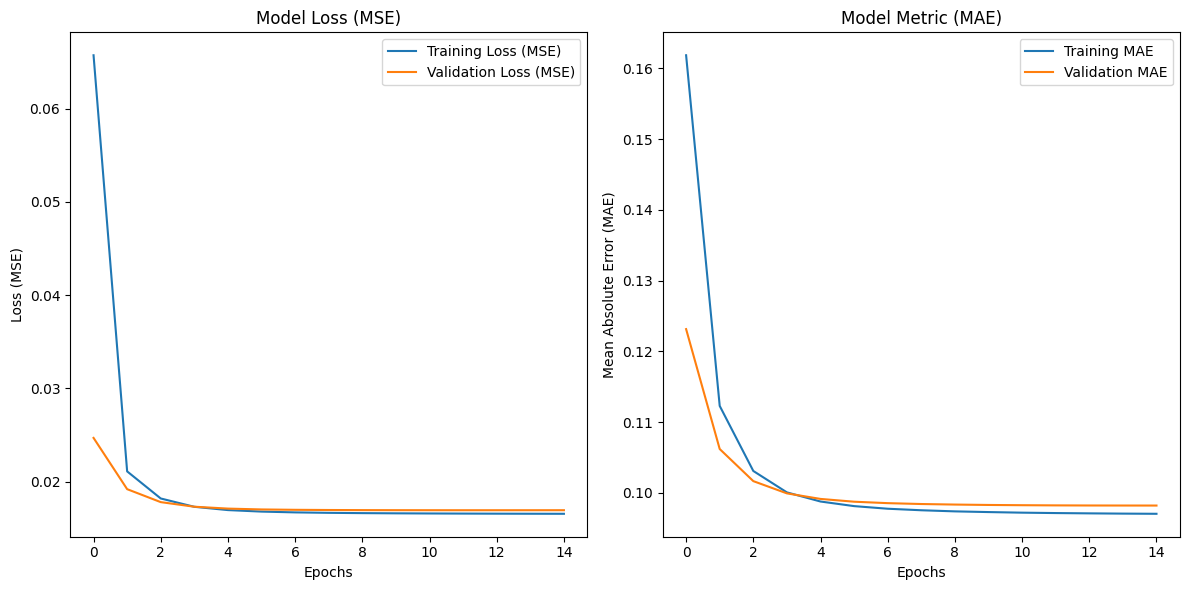

In [76]:
# Plot the training history
plt.figure(figsize=(12, 6))

# Plot the training and validation loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot the training and validation metric (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Metric (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

plt.tight_layout()
plt.show()

Dari hasil evaluasi model, kita dapat melihat bahwa model Collaborative Filtering yang telah kita buat memiliki nilai mean squared error sebesar `0.0165` dan nilai mean absolute error sebesar `0.0969`. Nilai ini menunjukkan bahwa model Collaborative Filtering yang telah kita buat memiliki performa yang baik dalam memprediksi rating yang diberikan oleh pengguna.

In [77]:
def get_model_recommendations(user_id, model, anime, anime_id_mapping, inverse_anime_id_mapping, rating, n=10):
    # Map the user_id to the internal user_id used in the model
    mapped_user_id = user_id_mapping.get(user_id, None)
    if mapped_user_id is None:
        raise ValueError(f"User ID {user_id} tidak ditemukan dalam user_id_mapping.")

    # Get the list of all anime IDs
    all_anime_ids = np.array(list(anime_id_mapping.values()))

    # Create an array with the user_id repeated for each anime_id
    user_anime_array = np.array([[mapped_user_id, anime_id] for anime_id in all_anime_ids])

    # Predict the ratings for all anime for the given user
    predicted_ratings = model.predict(user_anime_array).flatten()

    # Get the indices of the top n anime with the highest predicted ratings
    top_n_indices = predicted_ratings.argsort()[-n:][::-1]

    # Get the anime IDs for the top n recommendations
    top_n_anime_ids = [inverse_anime_id_mapping[idx] for idx in top_n_indices]

    # Get the top-rated anime for the user
    user_top_rated = rating[rating['user_id'] == mapped_user_id].sort_values(by='rating', ascending=False).head(n)
    user_top_rated_anime_ids = user_top_rated['anime_id'].map(inverse_anime_id_mapping).tolist()

    # Return the top-rated anime and the top n recommended anime
    top_rated_anime = anime[anime['anime_id'].isin(user_top_rated_anime_ids)][['anime_id', 'name', 'genre', 'rating', 'members']]
    recommended_anime = anime[anime['anime_id'].isin(top_n_anime_ids)][['anime_id', 'name', 'genre', 'rating', 'members']]
    
    return top_rated_anime, recommended_anime

In [78]:
# Mendapatkan ID pengguna random dari dataset
user_id = random.choice(list(user_id_mapping.keys()))
print(f"ID pengguna random: {user_id}")

# Mendapatkan anime dengan rating tertinggi dan rekomendasi untuk ID pengguna random
top_rated, recommendations = get_model_recommendations(user_id, model, anime, anime_id_mapping, inverse_anime_id_mapping, rating, n=5)

ID pengguna random: 54348
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [79]:
print(f"Anime dengan rating tertinggi dari User {user_id}:")
top_rated

Anime dengan rating tertinggi dari User 54348:


,anime_id,name,genre,rating,members
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",8.39,717796
282,2034,Lovely★Complex,"Comedy, Romance, Shoujo",8.23,235003
433,15,Eyeshield 21,"Action, Comedy, Shounen, Sports",8.08,83648
1631,2927,Kimikiss Pure Rouge,"Drama, Romance, School",7.48,58211
1748,5150,Hatsukoi Limited,"Comedy, Romance, School, Shounen",7.45,54796


In [80]:
print(f"Rekomendasi anime untuk User {user_id}:")
recommendations

Rekomendasi anime untuk User 54348:


,anime_id,name,genre,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",9.25,114262
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",9.16,151266
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",9.11,80679


Dari hasil rekomendasi Collaborative Filtering, kita dapat melihat bahwa anime yang direkomendasikan memiliki rating yang tinggi dan sesuai dengan preferensi pengguna. Selain itu, genre dari anime yang direkomendasikan juga memiliki kemiripan dengan genre anime yang telah ditonton oleh pengguna. Hal ini menunjukkan bahwa model Collaborative Filtering yang telah kita buat telah berhasil memberikan rekomendasi yang sesuai dengan preferensi pengguna.

# 6. Kesimpulan

---

Pada proyek ini, kita telah melakukan analisis data dan pembuatan model rekomendasi anime menggunakan dua pendekatan utama: **Content-Based Filtering** dan **Collaborative Filtering**. 

1. **Content-Based Filtering**:
    - Menggunakan algoritma **K-Nearest Neighbors (KNN)** untuk memberikan rekomendasi berdasarkan kesamaan genre anime.
    - Model ini berhasil memberikan rekomendasi anime yang memiliki genre mirip dengan anime yang telah ditonton oleh pengguna.

2. **Collaborative Filtering**:
    - Menggunakan model **RecommenderNet** yang dibangun dengan **TensorFlow** dan **Keras** untuk memberikan rekomendasi berdasarkan kesamaan preferensi pengguna.
    - Model ini dilatih menggunakan data rating pengguna dan berhasil memberikan rekomendasi anime yang sesuai dengan preferensi pengguna.

Hasil dari kedua pendekatan ini menunjukkan bahwa model rekomendasi yang telah dibuat memiliki performa yang baik dalam memberikan rekomendasi anime yang relevan dan sesuai dengan preferensi pengguna. Dengan demikian, proyek ini berhasil mencapai tujuan utamanya yaitu membuat sistem rekomendasi anime yang efektif.